In [9]:
import sys
import pyccl as ccl
import numpy as np
from clmm import Cosmology
from multiprocessing import Pool
import matplotlib.pyplot as plt
import emcee
import time
import pickle
def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()

sys.path.append('/pbs/throng/lsst/users/cpayerne/CLCosmo_Sim/cluster_abundance')
import CL_COUNT_modeling_completeness as comp
import CL_COUNT_modeling_purity as pur
import CL_COUNT_modeling_halo_mass_function as hmf
import CL_COUNT_modeling_richness_mass_relation as rm_relation

import CL_COUNT_cluster_abundance as cl_count
import CL_LENSING_cluster_lensing as cl_lensing

sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
import analysis_Mass_Richness_relation as analysis

In [3]:
#cosmology
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)
#halo model
massdef = ccl.halos.massdef.MassDef('vir', 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncDespali16(cosmo, mass_def=massdef)

#purity
richness0, p0, p1, np_ = 40, 0, 0, .2
theta_purity = [richness0, p0, p1, np_]
#completeness
logm0, c0, c1, nc = 13.3, 0, 0, 1
theta_completeness = [logm0, c0, c1, nc]
#rm_relation
log10m0, z0 = 14, .4
proxy_mu0, proxy_muz, proxy_mulog10m =  np.log(20), 0, 1
proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m =  .2, 0., 0
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]

richness_grid = np.logspace(np.log10(2), np.log10(500), 100)
logm_grid = np.linspace(11, 16, 101)
z_grid = np.linspace(.1, 1, 102)

In [4]:
grids = {'logm_grid': logm_grid, 'z_grid': z_grid, 'richness_grid':richness_grid}
count_modelling = {'dNdzdlogMdOmega':None,'richness_mass_relation':None, 'completeness':None, 'purity':None }
params = {'params_purity':theta_purity, 'params_completeness': theta_completeness, 'params_richness_mass_relation': theta_rm,
         'CCL_cosmology': cosmo, 'halo_mass_distribution': hmd}
adds = {'add_purity':False, 'add_completeness':False}
compute = {'compute_dNdzdlogMdOmega':True,'compute_richness_mass_relation':True, 'compute_completeness':True, 'compute_purity':True }

count_modelling_new = cl_count.recompute_count_modelling(count_modelling, grids = grids, compute = compute, params = params)

data = np.load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/notebooks/data_for_notebooks/stacked_esd_profiles_redmapper_true.pkl', allow_pickle=True)
profiles = data['stacked profile']
covariances = data['stacked covariance']
r = profiles['radius'][0]

#cluster_lensing = np.zeros([len(r), len(logm_grid), len(z_grid)])#
cluster_lensing = cl_lensing.compute_cluster_lensing(r, 'Duffy08', logm_grid, z_grid, cosmo, cosmo_clmm)

Z_bin = analysis.Z_bin
Richness_bin = analysis.Obs_bin
bins = {'redshift_bins':Z_bin, 'richness_bins': Richness_bin}
DS_obs = np.zeros([len(r), len(Richness_bin), len(Z_bin)])
Err_obs = np.zeros([len(r), len(Richness_bin), len(Z_bin)])

for i, z_bin in enumerate(Z_bin):
    mask_z = (profiles['z_mean'] > z_bin[0])*(profiles['z_mean'] < z_bin[1])
    for j, richness_bin in enumerate(Richness_bin):
        mask_richness = (profiles['obs_mean'] > richness_bin[0])*(profiles['obs_mean'] < richness_bin[1])
        mask_tot = mask_z * mask_richness
        DS_obs[:,j,i] = profiles['gt'][mask_tot][0]
        Err_obs[:,j,i] = covariances['cov_t'][mask_tot][0].diagonal()**.5

def DS(theta):
    
    proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0 = theta
    if proxy_sigma0 < 0: return -np.inf
    theta_rm_new = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, 0, 0]
    
    params_new = {'params_purity':theta_purity, 
                  'params_completeness': theta_completeness, 
                  'params_richness_mass_relation': theta_rm_new,
                  'CCL_cosmology': cosmo, 
                  'halo_mass_distribution': hmd}
    compute_new = {'compute_dNdzdlogMdOmega':False,
                   'compute_richness_mass_relation':True, 
                   'compute_completeness':False, 
                   'compute_purity':False}

    count_modelling_new = cl_count.recompute_count_modelling(count_modelling, grids = grids, compute = compute_new, params = params_new)
    integrand_count_new = cl_count.define_count_integrand(count_modelling_new, adds)
    Omega = 1
    NDS_profiles = Omega * cl_lensing.Cluster_dNd0mega_Lensing_ProxyZ(bins, integrand_count = integrand_count_new, 
                                                                      cluster_lensing = cluster_lensing, 
                                                                      lensing_radius = r, grids = grids)
    N = Omega * cl_count.Cluster_SurfaceDensity_ProxyZ(bins, integrand_count = integrand_count_new, grids = grids)
    DS_profiles = NDS_profiles/N
    lnL = -.5*np.sum(((DS_profiles - DS_obs)/Err_obs)**2)
    return DS_profiles

In [58]:
theta = [ 1.74558915, -0.84962514,  1.63437763,  0.86037844]

In [60]:
DS_mod = DS(theta)

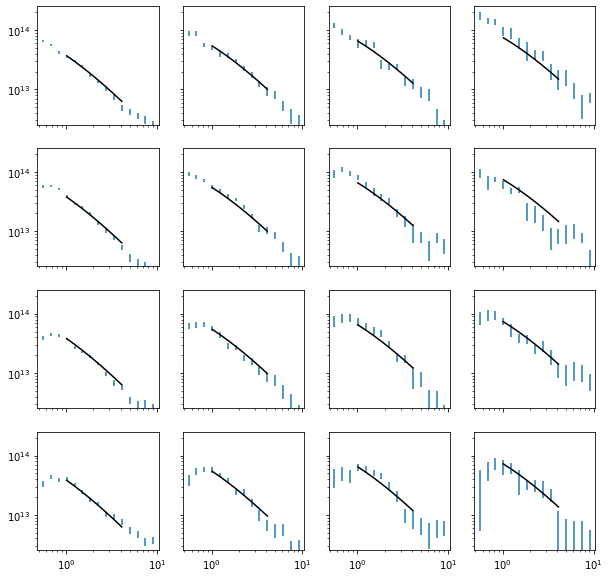

In [64]:
fig, ax = plt.subplots(len(Z_bin), len(Richness_bin), figsize=(10,10), sharey = True, sharex = True)
for i, z_bin in enumerate(Z_bin):
    for j, richness_bin in enumerate(Richness_bin):
        a = 1
        #ax[i,j].loglog(r, DS_mod[:,j,i])
        ax[i,j].loglog(r[(r > 1)*(r < 5)], DS_mod[:,j,i][(r > 1)*(r < 5)], 'k')
        ax[i,j].errorbar(r, DS_obs[:,j,i], Err_obs[:,j,i], fmt = ' ')